In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(346712, 828)
(346712, 1)
validation
(56968, 828)
(56968, 1)
test
(29712, 828)
(29712, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/35 [..............................] - ETA: 50s - loss: 0.0125 - STD: 4.7286e-04 - MAE: 0.0809

 4/35 [==>...........................] - ETA: 0s - loss: 0.0182 - STD: 9.4720e-04 - MAE: 0.0979 

 5/35 [===>..........................] - ETA: 7s - loss: 0.0181 - STD: 0.0012 - MAE: 0.1019    

 8/35 [=====>........................] - ETA: 3s - loss: 0.0161 - STD: 0.0016 - MAE: 0.0897

10/35 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 0.0018 - MAE: 0.0853

11/35 [========>.....................] - ETA: 2s - loss: 0.0153 - STD: 0.0020 - MAE: 0.0833

12/35 [=========>....................] - ETA: 2s - loss: 0.0150 - STD: 0.0021 - MAE: 0.0829

13/35 [==========>...................] - ETA: 2s - loss: 0.0149 - STD: 0.0023 - MAE: 0.0835

14/35 [===========>..................] - ETA: 2s - loss: 0.0148 - STD: 0.0025 - MAE: 0.0842

15/35 [===========>..................] - ETA: 1s - loss: 0.0146 - STD: 0.0027 - MAE: 0.0842

16/35 [============>.................] - ETA: 1s - loss: 0.0144 - STD: 0.0028 - MAE: 0.0833

17/35 [=============>................] - ETA: 1s - loss: 0.0142 - STD: 0.0030 - MAE: 0.0822

18/35 [==============>...............] - ETA: 1s - loss: 0.0141 - STD: 0.0031 - MAE: 0.0810

19/35 [===============>..............] - ETA: 1s - loss: 0.0140 - STD: 0.0033 - MAE: 0.0800

20/35 [================>.............] - ETA: 1s - loss: 0.0139 - STD: 0.0035 - MAE: 0.0790

21/35 [=================>............] - ETA: 1s - loss: 0.0137 - STD: 0.0037 - MAE: 0.0780

22/35 [=================>............] - ETA: 1s - loss: 0.0136 - STD: 0.0039 - MAE: 0.0774

23/35 [==================>...........] - ETA: 0s - loss: 0.0135 - STD: 0.0041 - MAE: 0.0772

24/35 [===================>..........] - ETA: 0s - loss: 0.0133 - STD: 0.0044 - MAE: 0.0772

25/35 [====================>.........] - ETA: 0s - loss: 0.0133 - STD: 0.0047 - MAE: 0.0771

26/35 [=====================>........] - ETA: 0s - loss: 0.0132 - STD: 0.0050 - MAE: 0.0770

27/35 [======================>.......] - ETA: 0s - loss: 0.0130 - STD: 0.0053 - MAE: 0.0765

28/35 [=======================>......] - ETA: 0s - loss: 0.0129 - STD: 0.0057 - MAE: 0.0759

29/35 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 0.0061 - MAE: 0.0753

30/35 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 0.0065 - MAE: 0.0746

31/35 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.0070 - MAE: 0.0740

32/35 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0075 - MAE: 0.0735

33/35 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0081 - MAE: 0.0731

34/35 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.0088 - MAE: 0.0728

35/35 [==============================] - ETA: 0s - loss: 0.0121 - STD: 0.0095 - MAE: 0.0725

35/35 [==============================] - 5s 95ms/step - loss: 0.0121 - STD: 0.0095 - MAE: 0.0725 - val_loss: 0.0083 - val_STD: 0.0374 - val_MAE: 0.0586


Epoch 2/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0080 - STD: 0.0384 - MAE: 0.0587

 2/35 [>.............................] - ETA: 1s - loss: 0.0077 - STD: 0.0400 - MAE: 0.0565

 3/35 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.0419 - MAE: 0.0551

 4/35 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.0441 - MAE: 0.0542

 5/35 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.0466 - MAE: 0.0540

 6/35 [====>.........................] - ETA: 1s - loss: 0.0071 - STD: 0.0493 - MAE: 0.0537

 7/35 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0521 - MAE: 0.0537

 8/35 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.0549 - MAE: 0.0536

 9/35 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0573 - MAE: 0.0534

10/35 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0595 - MAE: 0.0532

11/35 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0613 - MAE: 0.0531

12/35 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0630 - MAE: 0.0528

13/35 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0646 - MAE: 0.0526

14/35 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0661 - MAE: 0.0522

15/35 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0674 - MAE: 0.0519

16/35 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0515

17/35 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0689 - MAE: 0.0511

18/35 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0692 - MAE: 0.0507

19/35 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0693 - MAE: 0.0504

20/35 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0694 - MAE: 0.0501

21/35 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0697 - MAE: 0.0498

22/35 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0701 - MAE: 0.0496

23/35 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0705 - MAE: 0.0494

24/35 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0710 - MAE: 0.0492

25/35 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0716 - MAE: 0.0490

26/35 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0722 - MAE: 0.0488

27/35 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0486

28/35 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0738 - MAE: 0.0484

30/35 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0480

31/35 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0479

32/35 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0477

33/35 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0476

34/35 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0763 - MAE: 0.0475

35/35 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0474

35/35 [==============================] - 2s 62ms/step - loss: 0.0051 - STD: 0.0765 - MAE: 0.0474 - val_loss: 0.0045 - val_STD: 0.0705 - val_MAE: 0.0422


Epoch 3/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0766 - MAE: 0.0434

 2/35 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0781 - MAE: 0.0439

 3/35 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0436

 4/35 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0436

 5/35 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0434

 6/35 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0434

 7/35 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0844 - MAE: 0.0433

 8/35 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0849 - MAE: 0.0433

 9/35 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0434

10/35 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0434

11/35 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0863 - MAE: 0.0434

12/35 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0434

13/35 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0862 - MAE: 0.0433

14/35 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0860 - MAE: 0.0433

15/35 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0857 - MAE: 0.0434

16/35 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0856 - MAE: 0.0434

17/35 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0858 - MAE: 0.0434

18/35 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0859 - MAE: 0.0434

19/35 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0860 - MAE: 0.0433

20/35 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0862 - MAE: 0.0433

21/35 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0862 - MAE: 0.0433

22/35 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0433

23/35 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0433

24/35 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0433

25/35 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0433

26/35 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0433

27/35 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0433

28/35 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0433

29/35 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0433

30/35 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0863 - MAE: 0.0433

31/35 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0433

32/35 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0433

33/35 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0433

34/35 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0433

35/35 [==============================] - 2s 62ms/step - loss: 0.0043 - STD: 0.0867 - MAE: 0.0433 - val_loss: 0.0043 - val_STD: 0.0798 - val_MAE: 0.0418


Epoch 4/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0866 - MAE: 0.0424

 2/35 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0876 - MAE: 0.0427

 3/35 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0875 - MAE: 0.0432

 4/35 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0878 - MAE: 0.0432

 5/35 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0872 - MAE: 0.0431

 6/35 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0869 - MAE: 0.0431

 7/35 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0866 - MAE: 0.0431

 8/35 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0865 - MAE: 0.0431

 9/35 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0865 - MAE: 0.0430

10/35 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0867 - MAE: 0.0430

11/35 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0868 - MAE: 0.0430

12/35 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0868 - MAE: 0.0430

13/35 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0430

14/35 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0430

15/35 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0430

16/35 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0430

17/35 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0430

18/35 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0870 - MAE: 0.0430

19/35 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0869 - MAE: 0.0430

20/35 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0870 - MAE: 0.0429

21/35 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0870 - MAE: 0.0429

22/35 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0870 - MAE: 0.0429

23/35 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0429

24/35 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0429

26/35 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0873 - MAE: 0.0429

27/35 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0872 - MAE: 0.0428

28/35 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0428

29/35 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0428

30/35 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0428

31/35 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0428

32/35 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0428

33/35 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0428

34/35 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0427

35/35 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0871 - MAE: 0.0428

35/35 [==============================] - 2s 62ms/step - loss: 0.0041 - STD: 0.0871 - MAE: 0.0428 - val_loss: 0.0042 - val_STD: 0.0819 - val_MAE: 0.0414


Epoch 5/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0917 - MAE: 0.0430

 2/35 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0912 - MAE: 0.0425

 3/35 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0894 - MAE: 0.0422

 4/35 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0894 - MAE: 0.0423

 5/35 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0892 - MAE: 0.0424

 6/35 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0890 - MAE: 0.0423

 7/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0885 - MAE: 0.0423

 8/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0422

 9/35 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0876 - MAE: 0.0422

10/35 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0876 - MAE: 0.0422

11/35 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0877 - MAE: 0.0422

12/35 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0877 - MAE: 0.0422

13/35 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0877 - MAE: 0.0422

14/35 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0422

15/35 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0883 - MAE: 0.0424

16/35 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423

17/35 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423

18/35 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0423

19/35 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0423

20/35 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0877 - MAE: 0.0423

21/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0423

22/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0423

23/35 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0423

25/35 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0423

26/35 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0423

27/35 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423

28/35 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0423

29/35 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0423

30/35 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0423

31/35 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423

32/35 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0423

33/35 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0422

34/35 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0881 - MAE: 0.0423

35/35 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423

35/35 [==============================] - 2s 62ms/step - loss: 0.0040 - STD: 0.0880 - MAE: 0.0423 - val_loss: 0.0041 - val_STD: 0.0817 - val_MAE: 0.0409


Epoch 6/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0874 - MAE: 0.0426

 2/35 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0879 - MAE: 0.0428

 3/35 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0425

 4/35 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0425

 5/35 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0869 - MAE: 0.0423

 6/35 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0880 - MAE: 0.0425

 7/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0876 - MAE: 0.0424

 8/35 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0874 - MAE: 0.0424

 9/35 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0878 - MAE: 0.0423

10/35 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0883 - MAE: 0.0424

12/35 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0884 - MAE: 0.0422

13/35 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0886 - MAE: 0.0422

14/35 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0886 - MAE: 0.0421

15/35 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0883 - MAE: 0.0420

16/35 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0883 - MAE: 0.0420

17/35 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0884 - MAE: 0.0419

18/35 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0884 - MAE: 0.0420

19/35 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0885 - MAE: 0.0419

20/35 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0886 - MAE: 0.0419

21/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0418

22/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0889 - MAE: 0.0418

23/35 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0889 - MAE: 0.0418

24/35 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0890 - MAE: 0.0418

25/35 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0889 - MAE: 0.0418

26/35 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0418

27/35 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0418

28/35 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0418

29/35 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0885 - MAE: 0.0417

30/35 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0886 - MAE: 0.0417

31/35 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0886 - MAE: 0.0417

32/35 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0887 - MAE: 0.0417

33/35 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0416

34/35 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0416

35/35 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0888 - MAE: 0.0416

35/35 [==============================] - 2s 63ms/step - loss: 0.0039 - STD: 0.0888 - MAE: 0.0416 - val_loss: 0.0040 - val_STD: 0.0853 - val_MAE: 0.0410


Epoch 7/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0888 - MAE: 0.0416

 3/35 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0870 - MAE: 0.0409

 4/35 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0873 - MAE: 0.0409

 5/35 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0864 - MAE: 0.0409

 6/35 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0875 - MAE: 0.0410

 7/35 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0884 - MAE: 0.0410

 8/35 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0884 - MAE: 0.0411

 9/35 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0890 - MAE: 0.0411

10/35 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0410

11/35 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0410

12/35 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0410

13/35 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0892 - MAE: 0.0411

14/35 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0887 - MAE: 0.0410

15/35 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0887 - MAE: 0.0411

16/35 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0410

17/35 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0887 - MAE: 0.0410

18/35 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0891 - MAE: 0.0411

19/35 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0892 - MAE: 0.0410

20/35 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0410

21/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0410

22/35 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0410

23/35 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0409

24/35 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0409

25/35 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0409

26/35 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0409

27/35 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0409

28/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0409

29/35 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0409

30/35 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0898 - MAE: 0.0409

31/35 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0899 - MAE: 0.0409

32/35 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0408

33/35 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0408

34/35 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0897 - MAE: 0.0408

35/35 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0895 - MAE: 0.0408

35/35 [==============================] - 2s 61ms/step - loss: 0.0037 - STD: 0.0895 - MAE: 0.0408 - val_loss: 0.0045 - val_STD: 0.0936 - val_MAE: 0.0450


Epoch 8/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0989 - MAE: 0.0451

 2/35 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0464

 3/35 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0880 - MAE: 0.0444

 4/35 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0898 - MAE: 0.0442

 5/35 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0869 - MAE: 0.0446

 6/35 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0874 - MAE: 0.0439

 7/35 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0892 - MAE: 0.0440

 8/35 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0881 - MAE: 0.0442

 9/35 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0884 - MAE: 0.0437

10/35 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0896 - MAE: 0.0441

11/35 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0890 - MAE: 0.0441

12/35 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0886 - MAE: 0.0438

13/35 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0893 - MAE: 0.0440

14/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0894 - MAE: 0.0436

15/35 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0890 - MAE: 0.0436

16/35 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0889 - MAE: 0.0433

17/35 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0894 - MAE: 0.0434

18/35 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0894 - MAE: 0.0431

19/35 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0891 - MAE: 0.0430

20/35 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0893 - MAE: 0.0429

21/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0899 - MAE: 0.0428

22/35 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0899 - MAE: 0.0427

23/35 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0898 - MAE: 0.0426

24/35 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0425

25/35 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0425

26/35 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0424

27/35 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0423

28/35 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0422

30/35 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0420

31/35 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0420

32/35 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0420

33/35 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0419

34/35 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0898 - MAE: 0.0418

35/35 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0898 - MAE: 0.0418

35/35 [==============================] - 2s 62ms/step - loss: 0.0038 - STD: 0.0898 - MAE: 0.0418 - val_loss: 0.0039 - val_STD: 0.0870 - val_MAE: 0.0401


Epoch 9/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0888 - MAE: 0.0394

 2/35 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0883 - MAE: 0.0394

 3/35 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0891 - MAE: 0.0394

 4/35 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0909 - MAE: 0.0398

 5/35 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0913 - MAE: 0.0399

 6/35 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0398

 7/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0904 - MAE: 0.0397

 8/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0400

 9/35 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0399

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0400

11/35 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0400

12/35 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0909 - MAE: 0.0400

14/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0398

15/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0399

16/35 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0398

17/35 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0904 - MAE: 0.0398

18/35 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0904 - MAE: 0.0398

19/35 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0399

20/35 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0398

21/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0399

22/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0904 - MAE: 0.0398

23/35 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0398

24/35 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0398

25/35 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0398

26/35 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0398

27/35 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0398

28/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0398

29/35 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0905 - MAE: 0.0398

30/35 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0398

31/35 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0397

32/35 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0397

33/35 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0397

34/35 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0397

35/35 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0397

35/35 [==============================] - 2s 61ms/step - loss: 0.0035 - STD: 0.0906 - MAE: 0.0397 - val_loss: 0.0040 - val_STD: 0.0913 - val_MAE: 0.0410


Epoch 10/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0958 - MAE: 0.0409

 2/35 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0906 - MAE: 0.0412

 3/35 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0405

 4/35 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0921 - MAE: 0.0403

 6/35 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0914 - MAE: 0.0404

 7/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0401

 8/35 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0401

 9/35 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0916 - MAE: 0.0402

10/35 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0401

11/35 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0400

12/35 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0400

13/35 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0399

14/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0399

15/35 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0398

16/35 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0911 - MAE: 0.0397

17/35 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0398

18/35 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0397

19/35 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0396

20/35 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0396

21/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0396

22/35 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0914 - MAE: 0.0396

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0395

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0395

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0395

26/35 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0394

27/35 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0394

28/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0394

29/35 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0394

30/35 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0393

31/35 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0393

32/35 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0393

33/35 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0393

34/35 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0917 - MAE: 0.0393

35/35 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0916 - MAE: 0.0393

35/35 [==============================] - 2s 62ms/step - loss: 0.0034 - STD: 0.0916 - MAE: 0.0393 - val_loss: 0.0039 - val_STD: 0.0906 - val_MAE: 0.0406


Epoch 11/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0976 - MAE: 0.0415

 2/35 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0915 - MAE: 0.0419

 3/35 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0940 - MAE: 0.0429

 4/35 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0915 - MAE: 0.0431

 5/35 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0929 - MAE: 0.0424

 6/35 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0930 - MAE: 0.0418

 7/35 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0924 - MAE: 0.0416

 8/35 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0933 - MAE: 0.0420

 9/35 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0921 - MAE: 0.0420

10/35 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0918 - MAE: 0.0417

11/35 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0926 - MAE: 0.0418

12/35 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0915 - MAE: 0.0422

13/35 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0916 - MAE: 0.0419

14/35 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0923 - MAE: 0.0422

15/35 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0913 - MAE: 0.0426

16/35 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0910 - MAE: 0.0423

17/35 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0917 - MAE: 0.0429

18/35 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0910 - MAE: 0.0429

19/35 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0904 - MAE: 0.0429

20/35 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0911 - MAE: 0.0432

21/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0913 - MAE: 0.0430

22/35 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0908 - MAE: 0.0430

23/35 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0906 - MAE: 0.0429

24/35 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0911 - MAE: 0.0430

25/35 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0912 - MAE: 0.0428

26/35 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0908 - MAE: 0.0428

27/35 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0906 - MAE: 0.0426

28/35 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0909 - MAE: 0.0426

29/35 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0910 - MAE: 0.0426

30/35 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0908 - MAE: 0.0425

31/35 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0905 - MAE: 0.0424

32/35 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0907 - MAE: 0.0423

33/35 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0910 - MAE: 0.0423

34/35 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0908 - MAE: 0.0422

35/35 [==============================] - 2s 60ms/step - loss: 0.0038 - STD: 0.0906 - MAE: 0.0421 - val_loss: 0.0038 - val_STD: 0.0850 - val_MAE: 0.0385


Epoch 12/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0900 - MAE: 0.0385

 2/35 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0935 - MAE: 0.0401

 3/35 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0923 - MAE: 0.0397

 4/35 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0396

 5/35 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0898 - MAE: 0.0394

 6/35 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0906 - MAE: 0.0393

 7/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0394

 8/35 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0393

 9/35 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0907 - MAE: 0.0392

10/35 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0393

12/35 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0393

13/35 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0392

14/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0392

15/35 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0391

16/35 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0391

17/35 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0391

18/35 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0391

19/35 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0390

20/35 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0390

21/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0390

22/35 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0390

23/35 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0913 - MAE: 0.0390

24/35 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0390

25/35 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0911 - MAE: 0.0390

26/35 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0389

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0909 - MAE: 0.0389

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0909 - MAE: 0.0389

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0909 - MAE: 0.0389

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0910 - MAE: 0.0389

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0389

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0911 - MAE: 0.0388

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0388

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0388

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0914 - MAE: 0.0388

35/35 [==============================] - 2s 64ms/step - loss: 0.0033 - STD: 0.0914 - MAE: 0.0388 - val_loss: 0.0037 - val_STD: 0.0847 - val_MAE: 0.0385


Epoch 13/10000


 1/35 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0888 - MAE: 0.0386

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0905 - MAE: 0.0379

 3/35 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0909 - MAE: 0.0382

 4/35 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0913 - MAE: 0.0380

 5/35 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0909 - MAE: 0.0380

 6/35 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0382

 7/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0916 - MAE: 0.0382

 8/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0382

 9/35 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0383

10/35 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0383

11/35 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0384

12/35 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0384

13/35 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0384

14/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0385

15/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0384

16/35 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0385

17/35 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0385

18/35 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0385

19/35 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0385

20/35 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

21/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

22/35 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0386

23/35 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

24/35 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

25/35 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0386

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0386

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0386

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0923 - MAE: 0.0386

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0386

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0386

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0385

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0385

35/35 [==============================] - 2s 67ms/step - loss: 0.0033 - STD: 0.0924 - MAE: 0.0385 - val_loss: 0.0037 - val_STD: 0.0899 - val_MAE: 0.0387


Epoch 14/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0389

 2/35 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0912 - MAE: 0.0386

 3/35 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0910 - MAE: 0.0384

 4/35 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0385

 5/35 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0386

 6/35 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0386

 7/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0387

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0388

 9/35 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0387

10/35 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0386

11/35 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0925 - MAE: 0.0385

12/35 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0386

13/35 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0385

14/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0384

15/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0384

16/35 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0384

17/35 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0383

18/35 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0383

19/35 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0383

20/35 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0384

21/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0383

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0382

24/35 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0382

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0382

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0382

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0383

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0383

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0382

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0382

31/35 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0382

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0382

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0382

34/35 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0382

35/35 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0382

35/35 [==============================] - 2s 65ms/step - loss: 0.0032 - STD: 0.0928 - MAE: 0.0382 - val_loss: 0.0036 - val_STD: 0.0922 - val_MAE: 0.0384


Epoch 15/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0941 - MAE: 0.0384

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0918 - MAE: 0.0383

 3/35 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0938 - MAE: 0.0383

 4/35 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0382

 5/35 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0380

 6/35 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0381

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0920 - MAE: 0.0379

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0921 - MAE: 0.0378

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0925 - MAE: 0.0378

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0924 - MAE: 0.0378

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0379

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0379

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0379

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0379

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0378

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0378

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0378

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0378

20/35 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0378

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0379

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0380

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0937 - MAE: 0.0384

24/35 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0388

25/35 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0931 - MAE: 0.0389

26/35 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0932 - MAE: 0.0390

27/35 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0393

28/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0393

29/35 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0393

30/35 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0394

31/35 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0394

32/35 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0931 - MAE: 0.0394

33/35 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0394

34/35 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0394

35/35 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0394

35/35 [==============================] - 3s 73ms/step - loss: 0.0033 - STD: 0.0930 - MAE: 0.0394 - val_loss: 0.0039 - val_STD: 0.0825 - val_MAE: 0.0387


Epoch 16/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0872 - MAE: 0.0389

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0892 - MAE: 0.0382

 3/35 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0390

 4/35 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0920 - MAE: 0.0385

 5/35 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0916 - MAE: 0.0384

 6/35 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0384

 7/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0385

 8/35 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0926 - MAE: 0.0385

 9/35 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0383

10/35 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0384

11/35 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0383

12/35 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0382

13/35 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0382

14/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0925 - MAE: 0.0382

15/35 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0382

16/35 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0382

17/35 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0382

18/35 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0382

19/35 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0382

20/35 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0382

21/35 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0382

22/35 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0921 - MAE: 0.0381

23/35 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0381

24/35 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0381

25/35 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0381

26/35 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0381

27/35 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0381

28/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0922 - MAE: 0.0380

29/35 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0380

30/35 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0380

32/35 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0380

33/35 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0380

34/35 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0380

35/35 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0380

35/35 [==============================] - 3s 77ms/step - loss: 0.0032 - STD: 0.0924 - MAE: 0.0380 - val_loss: 0.0036 - val_STD: 0.0906 - val_MAE: 0.0379


Epoch 17/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0943 - MAE: 0.0378

 2/35 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0380

 3/35 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0928 - MAE: 0.0380

 4/35 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0379

 5/35 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0927 - MAE: 0.0379

 6/35 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0378

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0377

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0927 - MAE: 0.0377

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0378

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0378

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0378

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0378

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0378

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0377

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0377

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0376

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0376

20/35 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0375

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0375

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0375

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

26/35 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0375

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

33/35 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

35/35 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

35/35 [==============================] - 3s 75ms/step - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375 - val_loss: 0.0036 - val_STD: 0.0863 - val_MAE: 0.0379


Epoch 18/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0908 - MAE: 0.0372

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0921 - MAE: 0.0371

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0914 - MAE: 0.0373

 4/35 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0920 - MAE: 0.0372

 5/35 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0374

 6/35 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0925 - MAE: 0.0374

 7/35 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0375

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0930 - MAE: 0.0374

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0374

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0933 - MAE: 0.0373

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0372

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0373

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0373

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0373

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0373

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0373

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0373

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0373

20/35 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0374

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0375

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0375

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0375

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0375

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0375

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0375

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

33/35 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

35/35 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

35/35 [==============================] - 3s 76ms/step - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376 - val_loss: 0.0037 - val_STD: 0.0857 - val_MAE: 0.0385


Epoch 19/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0889 - MAE: 0.0378

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0918 - MAE: 0.0374

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0930 - MAE: 0.0377

 4/35 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0910 - MAE: 0.0380

 6/35 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0918 - MAE: 0.0388

 7/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0923 - MAE: 0.0388

 8/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0386

 9/35 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0926 - MAE: 0.0385

10/35 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0385

11/35 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0383

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0381

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0381

14/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0380

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0380

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0379

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0378

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0378

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0377

20/35 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0377

21/35 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

24/35 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

26/35 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0376

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0376

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0376

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0375

33/35 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0375

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0374

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0374

35/35 [==============================] - 3s 78ms/step - loss: 0.0030 - STD: 0.0936 - MAE: 0.0374 - val_loss: 0.0035 - val_STD: 0.0897 - val_MAE: 0.0374


Epoch 20/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0924 - MAE: 0.0366

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0370

 3/35 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0924 - MAE: 0.0370

 5/35 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0925 - MAE: 0.0373

 6/35 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0374

 7/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0931 - MAE: 0.0375

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0375

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0376

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0375

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0375

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0374

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0373

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0373

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0373

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0372

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0372

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0372

20/35 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0372

21/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0371

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0372

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0372

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0372

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0373

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0373

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0374

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0374

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0374

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0374

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0374

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0373

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0373

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0373

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0373

35/35 [==============================] - 3s 76ms/step - loss: 0.0030 - STD: 0.0940 - MAE: 0.0373 - val_loss: 0.0036 - val_STD: 0.0938 - val_MAE: 0.0382


Epoch 21/10000


 1/35 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0377

 2/35 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0919 - MAE: 0.0378

 3/35 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0932 - MAE: 0.0380

 4/35 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0920 - MAE: 0.0376

 5/35 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0926 - MAE: 0.0375

 7/35 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0373

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0373

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0371

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

11/35 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0370

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0369

13/35 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0370

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0935 - MAE: 0.0372

15/35 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0942 - MAE: 0.0375

16/35 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0377

17/35 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0378

18/35 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0377

19/35 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

20/35 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0376

21/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0376

22/35 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0376

23/35 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0376

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0375

25/35 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0942 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0376

27/35 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0376

28/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0376

29/35 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0376

30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0376

31/35 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0376

32/35 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0941 - MAE: 0.0376

33/35 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0375

34/35 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0940 - MAE: 0.0375

35/35 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375

35/35 [==============================] - 3s 76ms/step - loss: 0.0031 - STD: 0.0938 - MAE: 0.0375 - val_loss: 0.0035 - val_STD: 0.0853 - val_MAE: 0.0372


Epoch 22/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0910 - MAE: 0.0360

 2/35 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0932 - MAE: 0.0364

 3/35 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0363

 4/35 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0929 - MAE: 0.0362

 5/35 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0365

 6/35 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0937 - MAE: 0.0367

 7/35 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0369

 8/35 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0369

 9/35 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0369

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0369

11/35 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0368

12/35 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0369

13/35 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0369

14/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0368

15/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0368

16/35 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0368

18/35 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0367

19/35 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0367

20/35 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0367

22/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0368

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0369

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0370

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0371

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0371

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0371

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0371

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0371

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0370

35/35 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0370

35/35 [==============================] - 3s 76ms/step - loss: 0.0030 - STD: 0.0939 - MAE: 0.0370 - val_loss: 0.0036 - val_STD: 0.0934 - val_MAE: 0.0383


Epoch 23/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0984 - MAE: 0.0371

 2/35 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0371

 3/35 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0370

 4/35 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0369

 5/35 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0368

 6/35 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0366

 7/35 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0366

 8/35 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

 9/35 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0364

10/35 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0364

11/35 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0364

12/35 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0364

13/35 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0364

14/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0364

15/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

16/35 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0940 - MAE: 0.0365

17/35 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0366

18/35 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0369

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0371

20/35 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0371

21/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0371

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0371

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0372

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0374

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0375

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0374

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0374

28/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0375

29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0375

30/35 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0374

31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0374

32/35 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0374

33/35 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0374

34/35 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0374

35/35 [==============================] - 3s 75ms/step - loss: 0.0030 - STD: 0.0943 - MAE: 0.0374 - val_loss: 0.0035 - val_STD: 0.0850 - val_MAE: 0.0373


Epoch 24/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0881 - MAE: 0.0361

 2/35 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0361

 3/35 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0916 - MAE: 0.0365

 4/35 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0910 - MAE: 0.0364

 5/35 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0915 - MAE: 0.0363

 6/35 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0924 - MAE: 0.0364

 7/35 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0924 - MAE: 0.0364

 8/35 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0931 - MAE: 0.0364

 9/35 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0364

10/35 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0930 - MAE: 0.0362

11/35 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0931 - MAE: 0.0362

12/35 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0361

13/35 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0361

14/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0933 - MAE: 0.0362

15/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0362

16/35 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0362

17/35 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0363

18/35 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0362

19/35 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0363

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0364

22/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0364

23/35 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0364

24/35 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0940 - MAE: 0.0364

25/35 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0940 - MAE: 0.0364

26/35 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

27/35 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0364

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0364

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0364

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0364

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0363

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364

35/35 [==============================] - 3s 77ms/step - loss: 0.0029 - STD: 0.0943 - MAE: 0.0364 - val_loss: 0.0034 - val_STD: 0.0916 - val_MAE: 0.0372


Epoch 25/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0360

 2/35 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0358

 3/35 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0360

 4/35 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0363

 5/35 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0369

 6/35 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0378

 7/35 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0943 - MAE: 0.0384

 8/35 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0952 - MAE: 0.0384

 9/35 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0947 - MAE: 0.0381

10/35 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0378

11/35 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0951 - MAE: 0.0377

12/35 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0945 - MAE: 0.0377

13/35 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0949 - MAE: 0.0377

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0375

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0374

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0374

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0373

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0372

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0372

20/35 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0371

21/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0370

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0945 - MAE: 0.0369

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0946 - MAE: 0.0370

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0369

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0944 - MAE: 0.0369

27/35 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0369

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0368

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0368

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0368

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367

35/35 [==============================] - 3s 76ms/step - loss: 0.0029 - STD: 0.0944 - MAE: 0.0367 - val_loss: 0.0034 - val_STD: 0.0913 - val_MAE: 0.0371


Epoch 26/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0966 - MAE: 0.0358

 2/35 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0942 - MAE: 0.0354

 3/35 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0358

 4/35 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0358

 5/35 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0359

 6/35 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0358

 7/35 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0358

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0359

10/35 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0361

11/35 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0363

12/35 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0366

13/35 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0368

14/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0954 - MAE: 0.0371

15/35 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0372

16/35 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0949 - MAE: 0.0372

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0949 - MAE: 0.0372

18/35 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0371

19/35 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0952 - MAE: 0.0371

20/35 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0949 - MAE: 0.0371

21/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0951 - MAE: 0.0371

22/35 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0949 - MAE: 0.0371

23/35 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0370

24/35 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0948 - MAE: 0.0370

25/35 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0369

26/35 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0947 - MAE: 0.0369

27/35 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0369

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0368

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0368

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0368

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0367

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

35/35 [==============================] - 3s 76ms/step - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367 - val_loss: 0.0034 - val_STD: 0.0908 - val_MAE: 0.0372


Epoch 27/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0362

 2/35 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0937 - MAE: 0.0360

 3/35 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0932 - MAE: 0.0358

 4/35 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0360

 5/35 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0938 - MAE: 0.0360

 6/35 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0361

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0362

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0363

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0362

13/35 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0362

14/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0361

15/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0362

16/35 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0363

17/35 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0364

18/35 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0364

19/35 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0364

20/35 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0364

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0364

22/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0364

23/35 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0364

24/35 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0366

25/35 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

26/35 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0367

27/35 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0367

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0366

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0367

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0366

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0366

35/35 [==============================] - 2s 64ms/step - loss: 0.0029 - STD: 0.0946 - MAE: 0.0366 - val_loss: 0.0034 - val_STD: 0.0902 - val_MAE: 0.0369


Epoch 28/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0352

 2/35 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0354

 3/35 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0354

 4/35 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0354

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0356

 6/35 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0358

 8/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0356

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0358

10/35 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0360

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0362

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0362

13/35 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0362

14/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0362

15/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362

16/35 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0363

17/35 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0363

18/35 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0362

19/35 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0362

20/35 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0363

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0364

22/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0364

23/35 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0364

24/35 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0364

25/35 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0365

26/35 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0366

27/35 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0366

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0365

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0366

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0368

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0366

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0367

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367

35/35 [==============================] - 2s 61ms/step - loss: 0.0029 - STD: 0.0945 - MAE: 0.0367 - val_loss: 0.0035 - val_STD: 0.0874 - val_MAE: 0.0373


Epoch 29/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0922 - MAE: 0.0351

 2/35 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0359

 3/35 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0937 - MAE: 0.0363

 4/35 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0360

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0939 - MAE: 0.0360

 6/35 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0935 - MAE: 0.0359

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0937 - MAE: 0.0358

 8/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0938 - MAE: 0.0359

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0358

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0358

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0358

13/35 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0358

14/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0938 - MAE: 0.0358

15/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0359

16/35 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0359

17/35 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0359

18/35 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0358

19/35 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0358

20/35 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0358

21/35 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0358

22/35 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0358

23/35 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0358

24/35 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0359

25/35 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0361

26/35 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0362

27/35 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0362

28/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0362

29/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0362

30/35 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0363

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0363

32/35 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0362

33/35 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0362

34/35 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0362

35/35 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362

35/35 [==============================] - 2s 61ms/step - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362 - val_loss: 0.0034 - val_STD: 0.0880 - val_MAE: 0.0371


Epoch 30/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0924 - MAE: 0.0349

 2/35 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0350

 3/35 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0354

 4/35 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0354

 5/35 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0355

 6/35 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0357

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0359

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0360

10/35 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0359

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0359

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0358

13/35 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0357

14/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0358

15/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0357

16/35 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0358

17/35 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0358

18/35 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0361

19/35 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0364

20/35 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0364

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0364

22/35 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0363

23/35 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0363

24/35 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0362

25/35 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362

26/35 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0361

27/35 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0361

28/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0361

29/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0361

30/35 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0361

31/35 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0361

32/35 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0361

33/35 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0362

34/35 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0362

35/35 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362

35/35 [==============================] - 2s 61ms/step - loss: 0.0028 - STD: 0.0948 - MAE: 0.0362 - val_loss: 0.0035 - val_STD: 0.0850 - val_MAE: 0.0373


Epoch 31/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0354

 2/35 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0962 - MAE: 0.0366

 3/35 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0931 - MAE: 0.0366

 4/35 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0363

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0361

 6/35 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0359

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0360

 8/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0360

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0361

10/35 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0945 - MAE: 0.0359

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0359

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0359

13/35 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0358

14/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0358

15/35 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0358

16/35 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0357

17/35 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0357

18/35 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0357

19/35 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0358

20/35 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0358

21/35 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0357

22/35 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0357

23/35 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0357

24/35 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0357

25/35 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0357

27/35 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0357

28/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0357

29/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0357

30/35 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0357

31/35 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0357

32/35 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0356

33/35 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0356

34/35 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0356

35/35 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0357

35/35 [==============================] - 2s 62ms/step - loss: 0.0028 - STD: 0.0950 - MAE: 0.0357 - val_loss: 0.0035 - val_STD: 0.0959 - val_MAE: 0.0382


Epoch 32/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1047 - MAE: 0.0377

 2/35 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0368

 3/35 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0979 - MAE: 0.0362

 4/35 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0985 - MAE: 0.0361

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0362

 6/35 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0979 - MAE: 0.0367

 7/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0958 - MAE: 0.0372

 8/35 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0965 - MAE: 0.0374

 9/35 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0956 - MAE: 0.0372

10/35 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0954 - MAE: 0.0370

11/35 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0959 - MAE: 0.0370

12/35 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0955 - MAE: 0.0371

14/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0959 - MAE: 0.0368

15/35 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0955 - MAE: 0.0368

16/35 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0960 - MAE: 0.0369

17/35 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0952 - MAE: 0.0370

18/35 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0954 - MAE: 0.0370

19/35 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0369

20/35 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0370

21/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0370

22/35 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0369

23/35 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0368

24/35 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0368

25/35 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0368

26/35 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0368

27/35 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0368

28/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0367

29/35 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0367

30/35 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0952 - MAE: 0.0367

31/35 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0366

32/35 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0365

33/35 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0365

34/35 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0365

35/35 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0364

35/35 [==============================] - 2s 61ms/step - loss: 0.0029 - STD: 0.0949 - MAE: 0.0364 - val_loss: 0.0034 - val_STD: 0.0943 - val_MAE: 0.0375


Epoch 33/10000


 1/35 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0362

 2/35 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0368

 3/35 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0973 - MAE: 0.0365

 4/35 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0361

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0358

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0357

 8/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0357

 9/35 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0357

10/35 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0356

11/35 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0356

12/35 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0355

13/35 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0355

14/35 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0355

15/35 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0354

16/35 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0354

17/35 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0354

18/35 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0353

19/35 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0354

20/35 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0354

21/35 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0354

22/35 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0354

23/35 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0355

24/35 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0357

25/35 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0360

26/35 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0361

27/35 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0361

28/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0361

29/35 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0362

30/35 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0363

31/35 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0363

32/35 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0362

33/35 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0362

34/35 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0363

35/35 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0363

35/35 [==============================] - 2s 61ms/step - loss: 0.0028 - STD: 0.0953 - MAE: 0.0363 - val_loss: 0.0034 - val_STD: 0.0862 - val_MAE: 0.0368


Epoch 34/10000


 1/35 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0928 - MAE: 0.0350

 2/35 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0361

 3/35 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0938 - MAE: 0.0360

 5/35 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0358

 6/35 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0357

 7/35 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0356

 8/35 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0356

 9/35 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0355

10/35 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0356

11/35 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0355

12/35 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0355

13/35 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0355

14/35 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0944 - MAE: 0.0354

15/35 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0943 - MAE: 0.0354

16/35 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0354

17/35 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0943 - MAE: 0.0354

18/35 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0354

19/35 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0944 - MAE: 0.0353

20/35 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0353

21/35 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0946 - MAE: 0.0353

22/35 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0947 - MAE: 0.0353

23/35 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0353

24/35 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0949 - MAE: 0.0353

25/35 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0353

26/35 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0353

27/35 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0353

28/35 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0353

29/35 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0353

30/35 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0353

31/35 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0353

32/35 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0353

33/35 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0354

34/35 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0355

35/35 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0355

35/35 [==============================] - 2s 62ms/step - loss: 0.0027 - STD: 0.0950 - MAE: 0.0355 - val_loss: 0.0034 - val_STD: 0.0927 - val_MAE: 0.0380


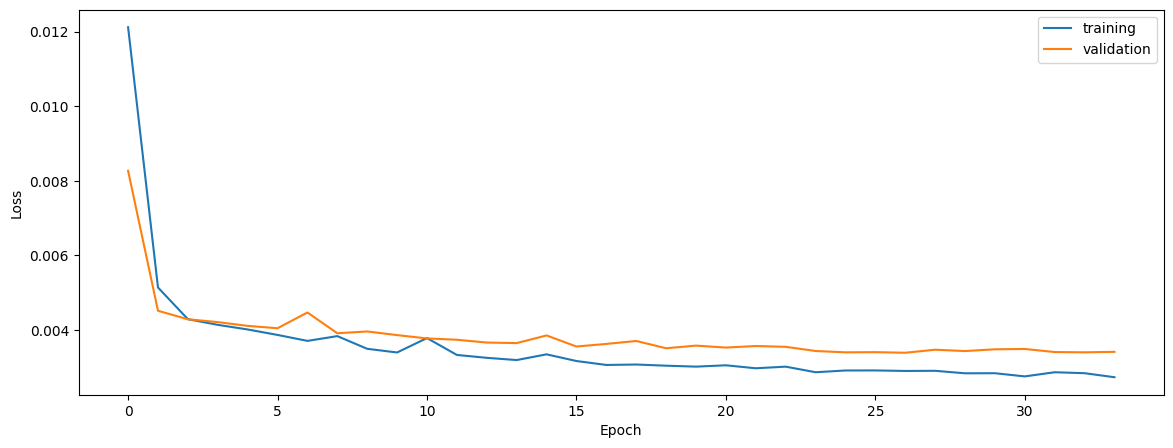

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


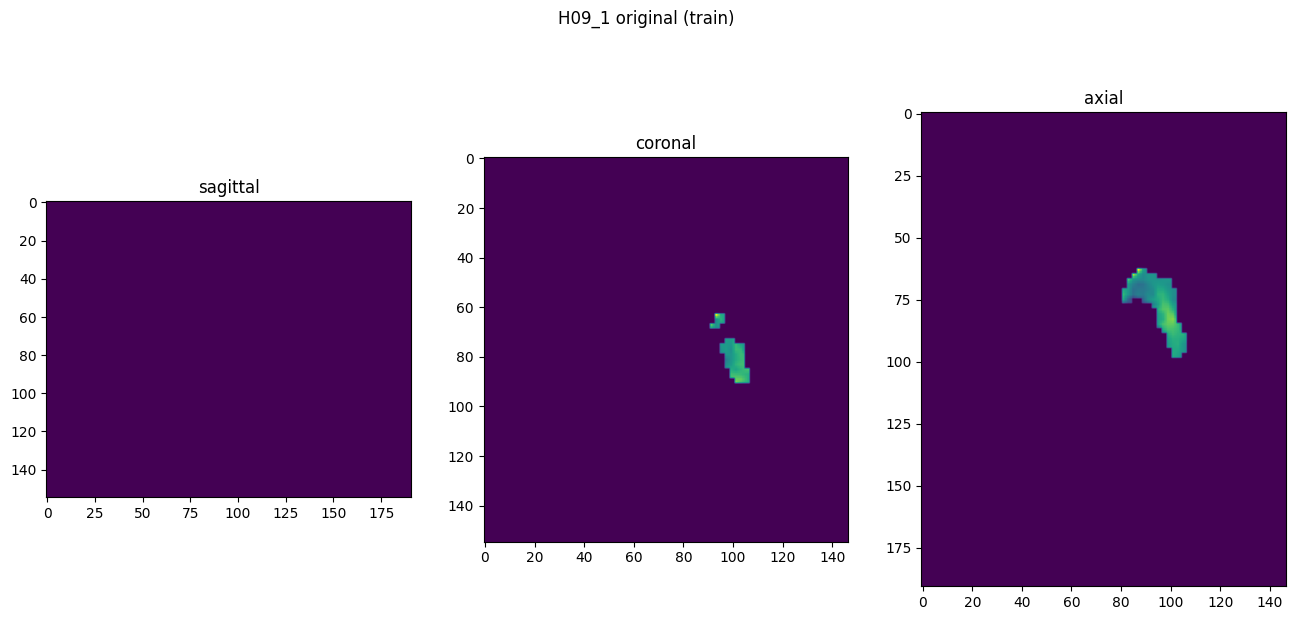

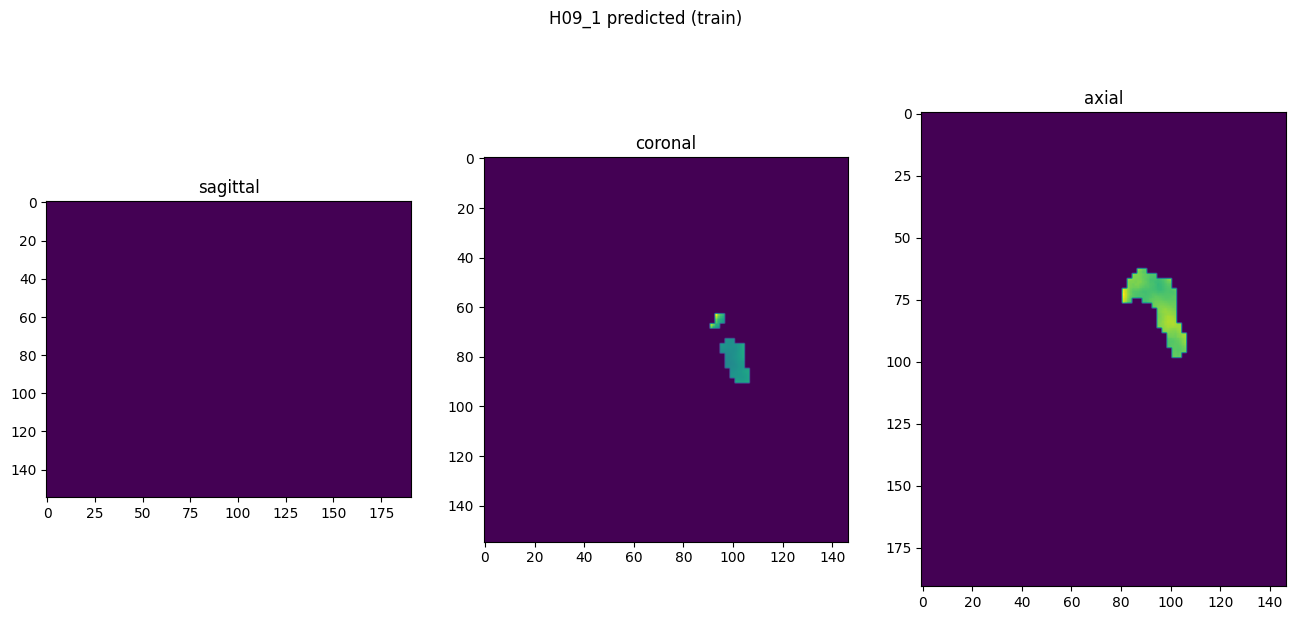

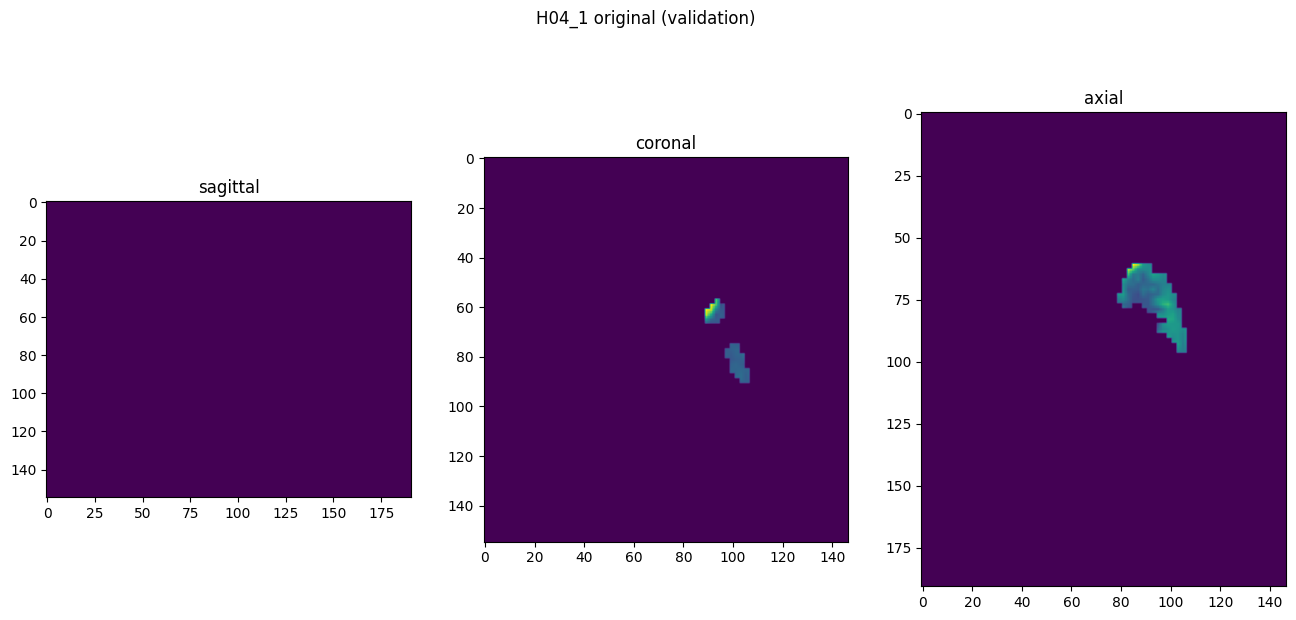

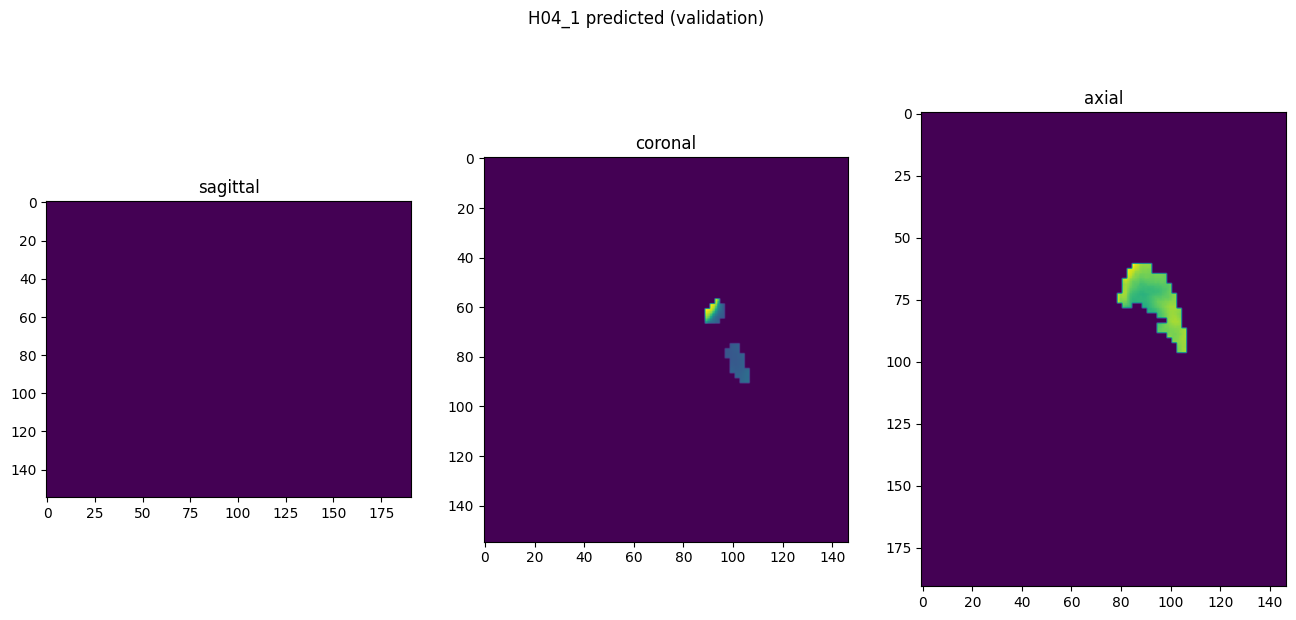

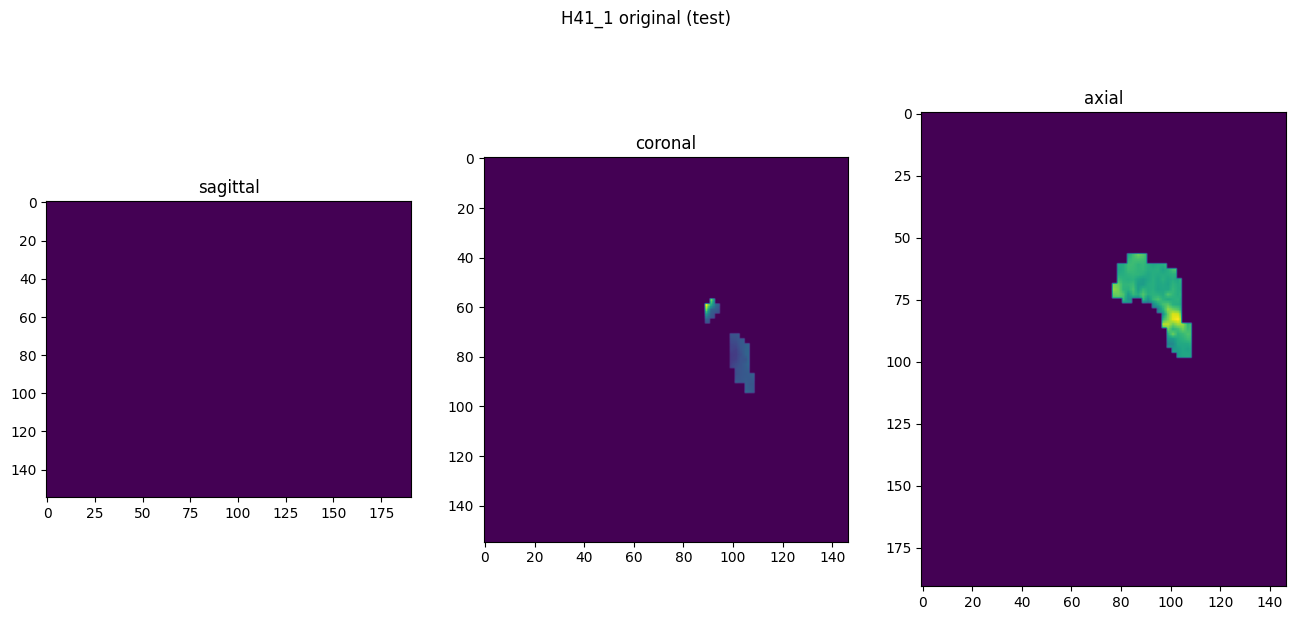

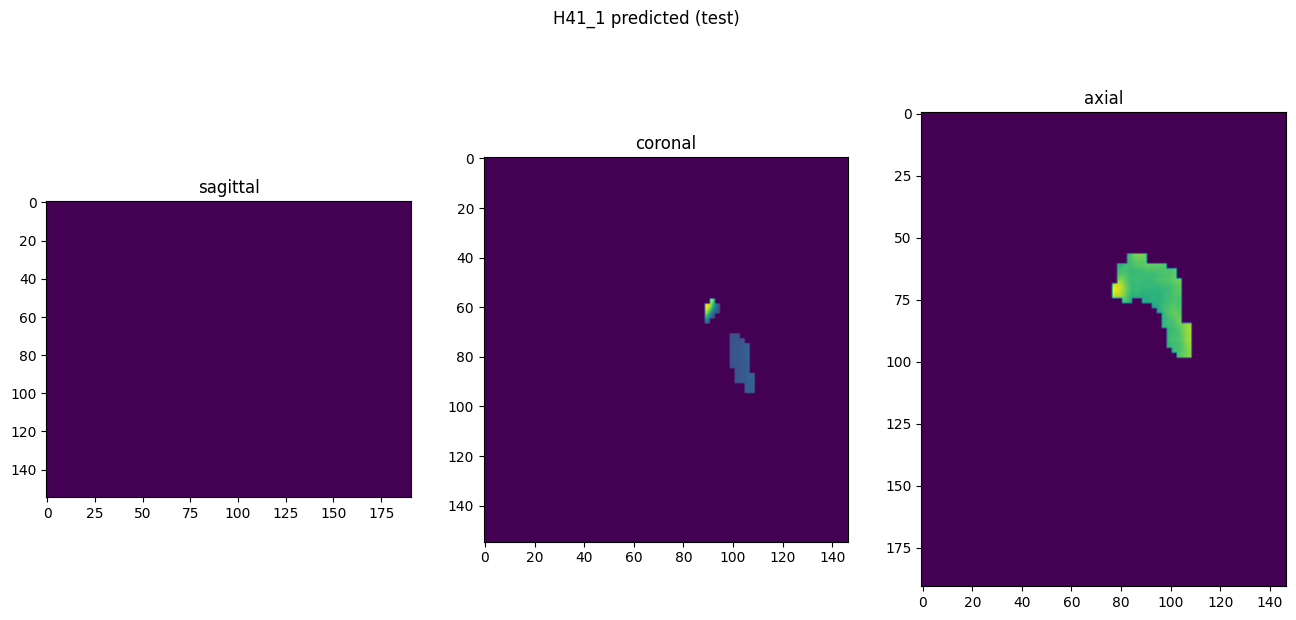

In [10]:
showResults(model, gen, threshold=None, background=False)